# Managing notebooks and working with Landsat 8 data

In this practical, we'll look at creating a new notebook from scratch, best practices for managing your code, and how to load and process a full Landsat 8 scene. This practical is best done by **creating a new (empty) notebook** and filling it in with your own notes and code.

## Preparation 

Before attempting this practical, please download the following scene from [EarthExplorer](https://earthexplorer.usgs.gov/) (you can use another scene if you'd like, just make sure it's Collection 2 Level 2 Landsat 8):

* Path/Row: 002/062
* Acquisition date: 2016/08/24
* Landsat 8 Collection 2 Level 2 
* All bands (1-7 and 10) as well as the `something_something_MTL.txt` metadata file

Instructions for downloading data from EarthExplorer: https://www.youtube.com/watch?v=Wn_G4fvitV8

Place all `.TIF` files in the **same folder** as this notebook.

## Imports

Start by loading the required libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.exposure

## Loading data 

First thing we need to do is load some data. To do that, let's make a function that reads in the bands we want.

In [2]:
def load_scene(prefix, bands):
    """
    Load the specified bands from a scene.
    
    Parameters:
    
    prefix 
        Name of the tif files without the band number and extension.
        For example, "LC08_L2SP_002062_20160824_20200906_02_T1" 
        (note that there is no _ at the end).
    bands
        List of bands to load.
        
    Returns:
    
    scene
        Dictionary with band numbers as keys and loaded band 
        (numpy array) as values.
    """
    # We'll store the scene in a dictionary where the keys are
    # the band numbers and the values are the loaded arrays.
    # This way, we can get band 2 using "scene[2]" instead of
    # "scene[1]", which is much less confusing.
    scene = {}
    for band in bands:
        if band == 10:
            product = "ST"
        else:
            product = "SR"
        fname = f"{prefix}_{product}_B{band}.TIF"
        scene[band] = skimage.io.imread(fname)
    return scene

In [3]:
scene = load_scene(prefix="LC08_L2SP_002062_20160824_20200906_02_T1", bands=[2, 3, 4, 5, 10])

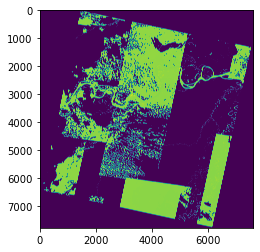

In [12]:
plt.figure()
plt.imshow(scene[10])

## Cropping to a region of interest

In [5]:
def crop(scene, west, east, north, south):
    """
    Crop a scene to the given pixel range.
    """
    cropped = {}
    for band in scene:
        # Notice that the scene is upside-down when plotted 
        # meaning that row 0 is the north of the scene.
        cropped[band] = scene[band][north : south, west : east]
    return cropped


In [6]:
scene_small = crop(scene, 2000, 5000, 1000, 4000)

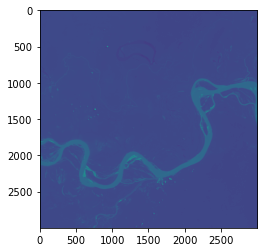

In [21]:
plt.figure()
plt.imshow(scene_small[4])

## Converting to surface reflectance and surface temperature

The loaded values of the bands are `uint16`.

In [8]:
def rescale(scene):
    """
    Convert a scene to surface reflectance.
    """
    scaled = {}
    for band in scene:
        if band == 10:
            multiply = 0.00341802
            add = 149.0
        else:
            multiply = 2.75e-05
            add = -0.2
        scaled[band] = scene[band] * multiply + add
    return scaled

In [9]:
scene_scaled = rescale(scene_small)

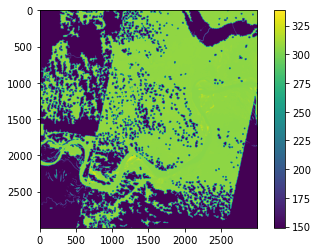

In [13]:
plt.imshow(scene_scaled[10])
plt.colorbar()

## Plotting composites

In [41]:
def composite(scene, bands, in_range):
    """
    """
    nrows, ncols = scene[bands[0]].shape
    result = np.empty((nrows, ncols, 3), dtype="uint8")
    for i, band in enumerate(bands):
        result[:, :, i] = skimage.exposure.rescale_intensity(
            scene[band], 
            in_range=in_range,
            out_range="uint8",
        )
    return result

In [64]:
truecolor = composite(scene_scaled, bands=[4, 3, 2], in_range=(0, 0.2))

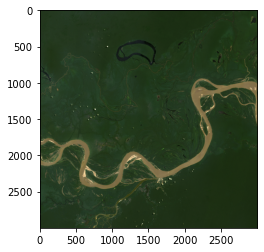

In [65]:
plt.figure()
plt.imshow(truecolor)

In [78]:
cir = composite(scene_scaled, bands=[5, 4, 3], in_range=(0, 0.5))

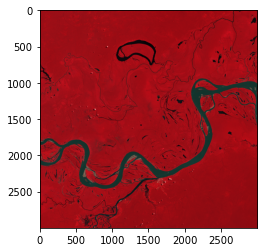

In [79]:
plt.figure()
plt.imshow(cir)

## Calculating indices

In [92]:
def ndvi(scene):
    """
    """
    result = (scene[5] - scene[4]) / (scene[5] + scene[4])
    return result

In [93]:
scene_ndvi = ndvi(scene_scaled)

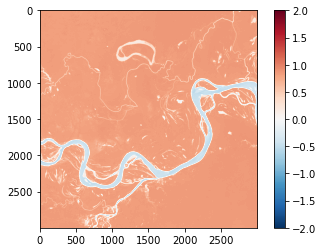

In [97]:
plt.figure()
plt.imshow(scene_ndvi, cmap="RdBu_r", vmax=2, vmin=-2)
plt.colorbar()